In [38]:
from libs import *
import string
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.set_option('display.max_colwidth', 50)
plt.style.use(['seaborn-whitegrid', 'seaborn-poster'])

In [ ]:
# Run this line to install the SpaCy English language model.
!python -m spacy download en_core_web_sm

# Data Preprocessing
<a id='contents'></a>
Before we can fit models to our Reddit post text data there are some important steps for us to undertake.

In this exercise our goal is to create a [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) (BoW) representation of out text. The approach is quite simplistic and doesn't take account of the order that words appear in, only whether they appear in a document or not. Despite this though BoW models have been shown to yield consistently good results.

1. [Initial data analysis](#section1)
2. [Data preprocessing steps](#section2)
3. [Vectorizers](#section3)

First we load some raw post data from a CSV file.

In [22]:
posts_file = '../datasets/all_reddit_labelled.csv'
df_posts = pd.read_csv(posts_file)
df_posts['created_at'] = pd.to_datetime(df_posts['created_at'])
df_posts = df_posts[~df_posts['label'].isin(['test strategy'])]

<a id='section1'></a>
## 1. Initial data analysis
[back](#contents)

[Initial data analysis](https://en.wikipedia.org/wiki/Data_analysis#Initial_data_analysis) is commonly the first step when starting a data science project. It give us a better understanding of the data and helps to identify any issues with the data that might prevent us from usiung the fdata in our modelling tasks (for example: missing data, inconsistent column values).

First lets look at some of the raw data. By default calling `head()` prints out the first 5 rows of data.

In [23]:
df_posts.head()

,title,score,num_comments,created_at,url,body,label
0,Live conversation via phone,3,2,2020-08-27 16:26:00,https://www.reddit.com/r/usertesting/comments/...,Hi guys I m quite confused. So i started this ...,live convo
1,What's a test with the most steps you've ever ...,6,9,2020-08-27 11:19:00,https://www.reddit.com/r/usertesting/comments/...,"I got one with 57 steps a while back, and just...",bad test
2,Preparing for Live Conversation,1,4,2020-08-27 10:44:00,https://www.reddit.com/r/usertesting/comments/...,Hi! Iâ€™ve been scheduled for a Live Test on A...,live convo
3,Mobile Test,0,8,2020-08-27 06:50:00,https://www.reddit.com/r/usertesting/comments/...,Hey yâ€™all...Iâ€™m about to take a test on my...,mobile
4,Curious about message,1,7,2020-08-27 06:49:00,https://www.reddit.com/r/usertesting/comments/...,&#x200B; [Anyone know what this is?](https://p...,other


Let's drill down in more detail on the title and body text (and label) from a random sample of 5 posts 

In [24]:
for i, row in df_posts[~df_posts['label'].isnull()].sample(n=5, random_state=42).iterrows():
    print('-------------------------')
    print(row['title'])
    print()
    print(row['body'])
    print()
    print('Label: ', row['label'])
    print()

-------------------------
Tell us the most broken / lame/ pathetic screeners you have seen in Usertesting

I'll start. * I have been asked if I'm pregnant (I'm male) * If I'm using IOS (on an android screener, DQ'ed when obviously said no) * Have seen HTML tags during the questions, cannot move forward * App buttons on android don't work so cannot move forward to accept a test (and the microphone bar doesn't move) * Qualified, then infinite spinner and the test never stars

Label:  screeners

-------------------------
Question

Has anyone ever been kicked out of usertesting? If so what for?

Label:  other

-------------------------
Thanksgiving Tests

This will be my first year doing this through the holiday season. Should I expect to receive screeners on Thursday or just don't even bother having it open?

Label:  other

-------------------------
Just lost a test because usertesting mobile app didn't pick sound from microphone. So I had to cancel the test. BAD

nan

Label:  recorder

-

Next we will look at the temporal distribution (when were these posts written? How many where written per week?).

Text(0, 0.5, '#\xa0of posts (weekly)')

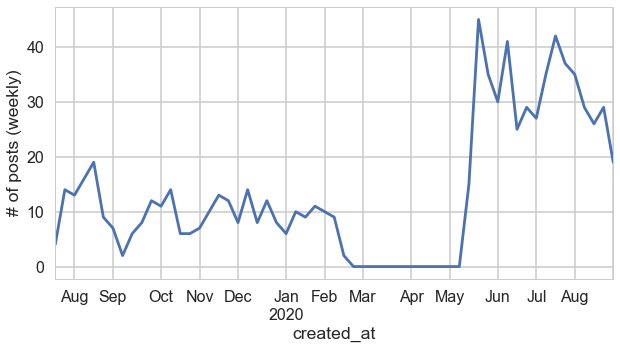

In [25]:
ax = df_posts.set_index('created_at').resample('W').size().plot(figsize=(10, 5))
ax.set_ylabel('# of posts (weekly)')

Finally, let's look at the labels and their prevalence in the dataset. Most categories appear with approximately similar frequency but the other category is much more frequent. We need to be conscious of this when we fit our models since inbalanced clases like this can lead to models with poor predictive accuracy. There are strategies we can use to address this though.

Text(0, 0.5, '# of posts')

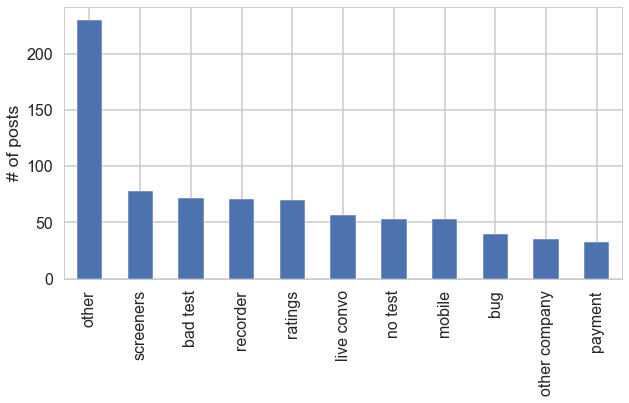

In [26]:
ax = df_posts['label'].value_counts().plot(kind='bar', figsize=(10, 5))
ax.set_ylabel('# of posts')

<a id='section2'></a>
## 2. Data preprocessing steps
[back](#contents)

The goal of preprocessing is to get our raw text data into a suitable form that we can use to train a machine learning model.

During this stage, text data is typically cleaned of superfluous 'noise' - for example extra white space, punctuation and very commonly used words (know as 'stop words') can be removed. 

Text is also normalized in order to reduce the size of the overall vocabulary - e.g. by converting text to lower cases so that for example 'Live Conversation' and 'live conversation' are treated in the same way. 

Note that the value of some preprocessing steps is highly dependent on the particular task and the source of the text. Some punctuation for example might be important to the meaning of the text - e.g. emoticons: `:)` `:(` ), but most of the steps we highlight here are commonly used in a range of applications with good results.

Consider the following text.

In [27]:
raw_text = "I love painting (I've always loved it) so I was running down the road with $10 in my hand to buy some more paints." \
    + " Unfortunately the shop was closed when I arrived!!??!"
print(raw_text)

I love painting (I've always loved it) so I was running down the road with $10 in my hand to buy some more paints. Unfortunately the shop was closed when I arrived!!??!


### Remove punctuation (cleaning)
We can remove all the punctuation from the text. Note that  here we choose to keep $ signs since we think they could be relevant to the task. `PUNCT_TO_REMOVE` is a list of symbol that we intend to remove from our text.

In [28]:

PUNCT_TO_REMOVE = string.punctuation.replace('$', '')
print(PUNCT_TO_REMOVE)

!"#%&'()*+,-./:;<=>?@[\]^_`{|}~


In [29]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

raw_text_np = remove_punctuation(raw_text)
print(raw_text_np)

I love painting Ive always loved it so I was running down the road with $10 in my hand to buy some more paints Unfortunately the shop was closed when I arrived


### Convert to lower (normalize)
Converting all the text to lower case reduces other overall size of the vocabulary.

In [30]:
raw_text_np_lower = raw_text_np.lower()
print(raw_text_np_lower)

i love painting ive always loved it so i was running down the road with $10 in my hand to buy some more paints unfortunately the shop was closed when i arrived


### Tokenising, removing stopwords and 'lemmatizing' text using Spacy

[Spacy](https://spacy.io/) is a NLP library that can be used to tokenise text and perform many cleaning and normalization tasks. It uses 'language models' that have been trained on a large corpus of text in the target language. The language model can be used to identify stop words and also perform 'lemmatization'. This is a process by which multiple words are mapped to their semantic 'root' For example:

`'loving', 'lover', 'loves', 'loved'`

can all be mapped to the root word 

`'love'`

First we create a model for our chosen language

In [31]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(raw_text_np_lower)

We can use the model to parse our text and pick out the 'tokens' that it is made up of.

In [32]:
print("")
print(list([t.text for t in doc]))


['i', 'love', 'painting', 'i', 've', 'always', 'loved', 'it', 'so', 'i', 'was', 'running', 'down', 'the', 'road', 'with', '$', '10', 'in', 'my', 'hand', 'to', 'buy', 'some', 'more', 'paints', 'unfortunately', 'the', 'shop', 'was', 'closed', 'when', 'i', 'arrived']


We can also use it to identify and therefore remove stop words

In [33]:
print(list([t.text for t in doc if not t.is_stop]))

['love', 'painting', 've', 'loved', 'running', 'road', '$', '10', 'hand', 'buy', 'paints', 'unfortunately', 'shop', 'closed', 'arrived']


Finally we can use the parsed tokens to convert word to their lemmatized root, further normalizing out text

In [34]:
print(list([t.lemma_ for t in doc if not t.is_stop]))

['love', 'painting', 'have', 'love', 'run', 'road', '$', '10', 'hand', 'buy', 'paint', 'unfortunately', 'shop', 'close', 'arrive']


It does this by first identifying parts of speech (using a pre-training NLP model):

In [35]:
print(list([t.pos_ for t in doc if not t.is_stop]))

['VERB', 'NOUN', 'VERB', 'VERB', 'VERB', 'NOUN', 'SYM', 'NUM', 'NOUN', 'VERB', 'NOUN', 'ADV', 'NOUN', 'VERB', 'VERB']


The data is starting to look the way we want it for our model, much of the noise is removed and words have been mapped to thier root form

### Preprocessing pipeline

We can plug these steps together to create a pipline for our reddit post data. We will:
- Join the title and body of the post
- Clean up the white space in the document (e.g. get rid of new lines, tabs etc.)
- Convert to lowercase
- Remove most of the punctation
- Lemmatize the words using Spacy and remove the common 'stop words'

In [36]:
def lemmatize_and_remove_stop_words(text):
    doc = nlp(text)
    return " ".join([t.lemma_ for t in doc if not t.is_stop])

    
raw_texts = df_posts['title'].fillna(' ') + ' ' + df_posts['body'].fillna(' ')

print('** Before processing: **')
print(raw_texts[0])
print()


raw_texts = raw_texts.str.replace('[^\w\' ]', '')
raw_texts = raw_texts.str.lower()
raw_texts = raw_texts.map(remove_punctuation)

print('** After 1st stage of processing: **')
print(raw_texts[0])
print()

raw_texts = raw_texts.map(lemmatize_and_remove_stop_words)

print('** After 2nd stage of processing: **')
print(raw_texts[0])

** Before processing: **
Live conversation via phone Hi guys I m quite confused. So i started this month. Since yesterday, i got 3 tests on my dashboard saying "you are scheduled for a live interview...use zoom on your phone bla bla" Next to it, there is the phone icon yet when i clicked on the thing, i have to take a screener which all 3 times I failed which is disappointing. Anyways, is it normal they use this language "you are scheduled" which i m obviously not since i have to qualify 1st.

** After 1st stage of processing: **
live conversation via phone hi guys i m quite confused so i started this month since yesterday i got 3 tests on my dashboard saying you are scheduled for a live interviewuse zoom on your phone bla bla next to it there is the phone icon yet when i clicked on the thing i have to take a screener which all 3 times i failed which is disappointing anyways is it normal they use this language you are scheduled which i m obviously not since i have to qualify 1st

** Af

<a id='section3'></a>
## 3. Vectorizers
[back](#contents)

Once we have cleaned and normalized our text data, we need to convert it in to a form that machine learning models can uderstand - i.e. a bag of words. We do this using a vectorizer which maps each piece of text to an array of 1s and 0s indictating whether each word in our vocabulary appears in our text or not.

<img src="figures/count_vectorizer.png" width=500>

In the image above, we can see how 4 different country names would be represented by a [count vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) (which simply counts the number of occurences of each word). The length of the array is the length of our vocabulary which is the number of unique words that appear in all our text documents. If this number is too large, we typically throw away the tokens that occur least frequently throughout the corpus.

In the example below, we can see how each line in a very simple corpus of text can be represented as an array of 1s and 0s.

In [39]:
cv = CountVectorizer()

texts = [
    'she goes to the zoo',
    'he goes to bed',
    'they like icecream and they like pizza',
    'we go home and then go to bed'
]

bows = cv.fit_transform(texts)
pd.DataFrame(bows.toarray(), columns=cv.get_feature_names())

,and,bed,go,goes,he,home,icecream,like,pizza,she,the,then,they,to,we,zoo
0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1
1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,1,2,1,0,0,0,2,0,0,0
3,1,1,2,0,0,1,0,0,0,0,0,1,0,1,1,0


Vectorizers can also be used to encode combinations of words that appear sequentially (n-grams) for example we might want to count the occurences of all pairs of words in our text in addition to single words.

In [40]:
cv2gram = CountVectorizer(ngram_range=(1,2))

texts = [
    'she goes to the zoo',
    'he goes to the zoo',
]

bows_2gram = cv2gram.fit_transform(texts)
pd.DataFrame(bows_2gram.toarray(), columns=cv2gram.get_feature_names())

,goes,goes to,he,he goes,she,she goes,the,the zoo,to,to the,zoo
0,1,1,0,0,1,1,1,1,1,1,1
1,1,1,1,1,0,0,1,1,1,1,1


Another type of vectorizer that is commonly used is a [Term Frequency - Inverse Document Frequency vectorizer](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (tf-idf). This accounts for the frequency of each word within a specific document relative to it's frequency across the whole corpus.

In [41]:
tfidfv = TfidfVectorizer()

texts = [
    'she goes to the zoo',
    'he goes to bed',
    'they like icecream and they like pizza',
    'we go home and then go to bed'
]

tfidf_bows = tfidfv.fit_transform(texts)
pd.DataFrame(np.round(tfidf_bows.toarray(), 2), columns=tfidfv.get_feature_names())

,and,bed,go,goes,he,home,icecream,like,pizza,she,the,then,they,to,we,zoo
0,0.00,0.00,0.00,0.39,0.00,0.00,0.00,0.00,0.00,0.5,0.5,0.00,0.00,0.32,0.00,0.5
1,0.00,0.48,0.00,0.48,0.61,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.39,0.00,0.0
2,0.24,0.00,0.00,0.00,0.00,0.00,0.31,0.61,0.31,0.0,0.0,0.00,0.61,0.00,0.00,0.0
3,0.27,0.27,0.68,0.00,0.00,0.34,0.00,0.00,0.00,0.0,0.0,0.34,0.00,0.22,0.34,0.0


That's it for preprocessing, we now have our text in a form that our machine learning models can understand and learn from.